# Notebook para Análisis de Precios de Toyota Corolla

## Configuración y Carga de Datos



In [278]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import joblib

In [279]:
# Configuración de MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("toyota_parcial")

<Experiment: artifact_location='mlflow-artifacts:/576424483513881687', creation_time=1747861702848, experiment_id='576424483513881687', last_update_time=1747861702848, lifecycle_stage='active', name='toyota_parcial', tags={}>

In [280]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)

## Limpieza de datos

In [281]:
# Corregir la variable Doors y eliminar observaciones incorrectas
print("\nDistribución original de Doors:")
print(df['Doors'].value_counts())

# Eliminar coches con 2 puertas (observaciones probablemente erróneas)
df = df[df['Doors'] != 2]

#Corregir coches con 4 puertas (4 laterales → 5 contando el maletero)
df.loc[df['Doors'] == 4, 'Doors'] = 5

print("\nDistribución corregida de Doors:")
print(df['Doors'].value_counts())



Distribución original de Doors:
Doors
5    674
3    622
4    138
2      2
Name: count, dtype: int64

Distribución corregida de Doors:
Doors
5    812
3    622
Name: count, dtype: int64








## Exploración de Datos (EDA)



In [282]:
# Dimensiones del dataset
df.shape

(1434, 37)

In [283]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1434 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1434 non-null   int64 
 1   Model             1434 non-null   object
 2   Price             1434 non-null   int64 
 3   Age_08_04         1434 non-null   int64 
 4   Mfg_Month         1434 non-null   int64 
 5   Mfg_Year          1434 non-null   int64 
 6   KM                1434 non-null   int64 
 7   Fuel_Type         1434 non-null   object
 8   HP                1434 non-null   int64 
 9   Met_Color         1434 non-null   int64 
 10  Automatic         1434 non-null   int64 
 11  cc                1434 non-null   int64 
 12  Doors             1434 non-null   int64 
 13  Cylinders         1434 non-null   int64 
 14  Gears             1434 non-null   int64 
 15  Quarterly_Tax     1434 non-null   int64 
 16  Weight            1434 non-null   int64 
 17  Mfr_Guarantee     1

In [284]:
# Estadísticas descriptivas
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,...,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000
mean,721.272664,10734.493724,55.930265,5.546722,1999.626918,68476.022315,101.532775,0.675035,0.055788,1576.753835,...,0.580893,0.562762,0.978382,0.146444,0.257322,0.300558,0.771269,0.205021,0.145746,0.277545
std,416.656357,3628.157569,18.607171,3.354114,1.541109,37484.964817,14.966978,0.468525,0.229592,424.472672,...,0.493585,0.496218,0.145483,0.353674,0.437311,0.458661,0.420162,0.403858,0.352975,0.447944
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.250000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,720.500000,9900.000000,61.000000,5.000000,1999.000000,63297.000000,110.000000,1.000000,0.000000,1600.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1080.750000,11950.000000,70.000000,8.000000,2001.000000,87000.000000,110.000000,1.000000,0.000000,1600.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [285]:
# Lista de columnas
print(df.columns.tolist())

['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Tow_Bar']


In [286]:
# Verificación de valores nulos
df.isnull().sum()

Id                  0
Model               0
Price               0
Age_08_04           0
Mfg_Month           0
Mfg_Year            0
KM                  0
Fuel_Type           0
HP                  0
Met_Color           0
Automatic           0
cc                  0
Doors               0
Cylinders           0
Gears               0
Quarterly_Tax       0
Weight              0
Mfr_Guarantee       0
BOVAG_Guarantee     0
Guarantee_Period    0
ABS                 0
Airbag_1            0
Airbag_2            0
Airco               0
Automatic_airco     0
Boardcomputer       0
CD_Player           0
Central_Lock        0
Powered_Windows     0
Power_Steering      0
Radio               0
Mistlamps           0
Sport_Model         0
Backseat_Divider    0
Metallic_Rim        0
Radio_cassette      0
Tow_Bar             0
dtype: int64

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7316\3039655210.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Fuel_Type", palette="pastel")


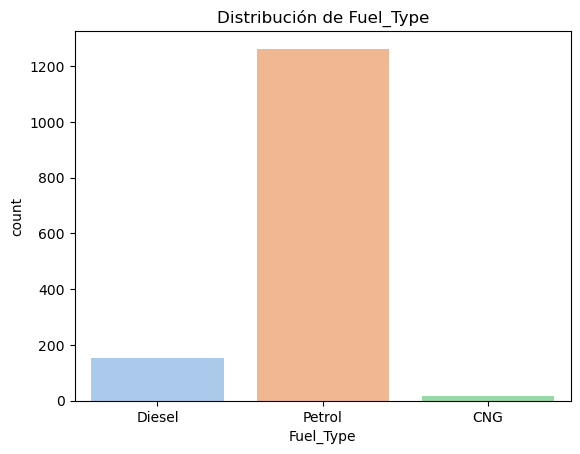

In [287]:
# Análisis de variables categóricas
sns.countplot(data=df, x="Fuel_Type", palette="pastel")
plt.title("Distribución de Fuel_Type")
plt.show()

In [288]:
# Búsqueda de duplicados
def find_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifica filas duplicadas completas en el DataFrame.
    """
    mask = df.duplicated(keep='first')
    duplicates = df[mask].copy()
    return duplicates

duplicates = find_duplicates(df)
print(f"Número de filas duplicadas: {len(duplicates)}")
if len(duplicates) > 0:
    print("Filas duplicadas:")
    print(duplicates)

Número de filas duplicadas: 0


In [289]:
# Generamos matriz de correlación para el análisis exploratorio
corr = df.select_dtypes(include=['number']).corr()

# Top correlaciones con Price
top_vars = (corr['Price']
            .abs()
            .sort_values(ascending=False)
            .head(11))   # Price + 10 más altas

print("Variables más correlacionadas con Price:")
print(top_vars)

Variables más correlacionadas con Price:
Price              1.000000
Mfg_Year           0.885122
Age_08_04          0.876521
Id                 0.738205
Boardcomputer      0.601034
Automatic_airco    0.588256
Weight             0.581697
KM                 0.569740
CD_Player          0.481110
Airco              0.428697
Powered_Windows    0.355821
Name: Price, dtype: float64


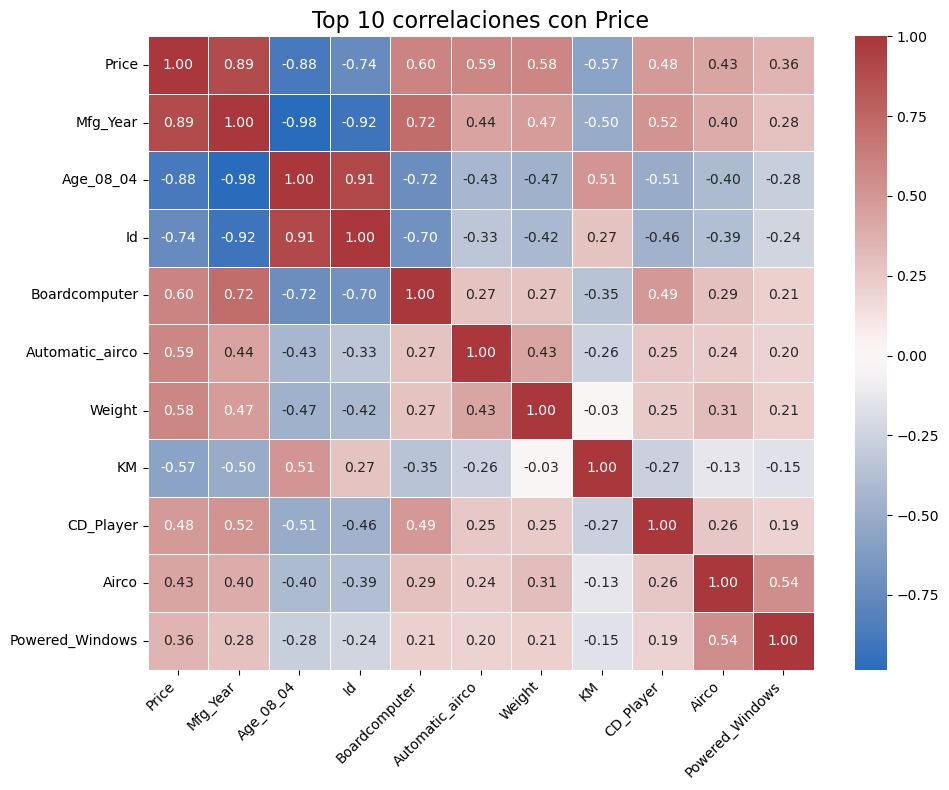

In [290]:
# Visualización de correlaciones principales
top_vars_idx = top_vars.index
sub_corr = corr.loc[top_vars_idx, top_vars_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(
    sub_corr,
    cmap="vlag",
    annot=True,
    fmt=".2f",
    linewidths=.5,
    center=0
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 correlaciones con Price", fontsize=16)
plt.tight_layout()
plt.show()

In [291]:
# Detección de outliers
def detect_outliers(df):
    cols = df.select_dtypes(include=np.number).columns
    outliers = pd.DataFrame(columns=['Feature', 'Number of Outliers'])
    
    for column in cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - (1.5*iqr)
        fence_high = q3 + (1.5*iqr)
        outliers_count = df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]
        
        outliers = pd.concat([outliers, pd.DataFrame({
            'Feature': [column], 
            'Number of Outliers': [outliers_count]
        })], ignore_index=True)
    
    return outliers.sort_values('Number of Outliers', ascending=False)

outlier_analysis = detect_outliers(df)
outlier_analysis

,Feature,Number of Outliers
31,Backseat_Divider,328
24,CD_Player,314
32,Metallic_Rim,294
18,ABS,267
13,Quarterly_Tax,222
28,Radio,210
33,Radio_cassette,209
17,Guarantee_Period,161
16,BOVAG_Guarantee,149
9,cc,122






















## Preprocesamiento y Feature Engineering



In [292]:
# Separar X (predictores) e y (variable objetivo)
y = df["Price"]

# Eliminar columnas no relevantes
X = df.drop(["Price", "Model", "Cylinders", "Id", "Radio_cassette", "BOVAG_Guarantee",
             "Backseat_Divider", "Mfg_Month", "Mfg_Year", "Automatic", "Central_Lock",
             "Met_Color", "Mfr_Guarantee", "Guarantee_Period", "Gears", "Radio", "Power_Steering",
             "Metallic_Rim", "Tow_Bar", "Sport_Model", "Mistlamps", "Fuel_Type"], axis=1)

print("Variables conservadas:")
print(X.columns.tolist())

Variables conservadas:
['Age_08_04', 'KM', 'HP', 'cc', 'Doors', 'Quarterly_Tax', 'Weight', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Powered_Windows']


In [ ]:
# Feature Engineering
X["Airbag_Count"] = df["Airbag_1"].fillna(0) + df["Airbag_2"].fillna(0)
X.drop(["Airbag_1", "Airbag_2"], axis=1, inplace=True)

# Codificación
X = pd.get_dummies(X, drop_first=True)

# Forzar tipos numéricos
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Eliminar filas con NaNs
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop("Price", axis=1)
y = combined["Price"]

# Convertir a float
X = X.astype(float)
y = y.astype(float)

# Guardar columnas originales para luego volver a agregar la constante
original_features = X.columns.tolist()

In [ ]:
# # Feature Engineering
# # Combinar airbags en una sola variable
# X["Airbag_Count"] = df["Airbag_1"].fillna(0) + df["Airbag_2"].fillna(0)
# X.drop(["Airbag_1", "Airbag_2"], axis=1, inplace=True)

# # Codificación de variables categóricas
# X = pd.get_dummies(X, drop_first=True)

# # Forzar tipos numéricos
# X = X.apply(pd.to_numeric, errors='coerce')
# y = pd.to_numeric(y, errors='coerce')

# # Eliminar filas con NaNs
# combined = pd.concat([X, y], axis=1).dropna()
# X = combined.drop("Price", axis=1)
# y = combined["Price"]

# # Convertir a float y agregar constante para OLS
# X = X.astype(float)
# y = y.astype(float)
# X = sm.add_constant(X)

# # División train-test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.4, random_state=1
# )

# print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")



## Modelo de Regresión Lineal (OLS)



In [ ]:
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# if mlflow.active_run() is not None:
#     mlflow.end_run()

with mlflow.start_run(run_name="ols_model_kfold"):

    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    # Acumuladores
    metrics = {
        "rmse": [], "mae": [], "r2_sklearn": [],
        "r2_statsmodels": [], "adj_r2": [],
        "aic": [], "bic": []
    }

    fold = 0
    
    for train_idx, test_idx in kf.split(X):
        fold += 1
        print(f"=== Fold {fold} ===")

        # Separar folds
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Agregar constante
        X_train_const = sm.add_constant(X_train)
        X_test_const  = sm.add_constant(X_test)

        model = sm.OLS(y_train, X_train_const)
        results = model.fit()
        y_pred = results.predict(X_test_const)

        # Métricas
        metrics["rmse"].append(root_mean_squared_error(y_test, y_pred))
        metrics["mae"].append(mean_absolute_error(y_test, y_pred))
        metrics["r2_sklearn"].append(r2_score(y_test, y_pred))
        metrics["r2_statsmodels"].append(results.rsquared)
        metrics["adj_r2"].append(results.rsquared_adj)
        metrics["aic"].append(results.aic)
        metrics["bic"].append(results.bic)

    # Log promedio de métricas a MLflow
    for key in metrics:
        mlflow.log_metric(f"{key}", float(np.mean(metrics[key])))
        mlflow.log_metric(f"{key}_std", float(np.std(metrics[key])))

    mlflow.log_metric("n_features", int(X.shape[1]))

    # Serializar modelo del último fold
    os.makedirs("mlartifacts", exist_ok=True)
    summary_path = os.path.join("mlartifacts", "ols_summary.txt")
    with open(summary_path, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_path)

    model_pkl = os.path.join("mlartifacts", "ols_model.pkl")
    joblib.dump(results, model_pkl)
    mlflow.log_artifact(model_pkl)

    features_path = os.path.join("mlartifacts", "features.txt")
    with open(features_path, "w") as f:
        f.write("\n".join(["const"] + original_features))
    mlflow.log_artifact(features_path)

    # VIF del último fold
    X_vif = sm.add_constant(X_train)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif_path = os.path.join("mlartifacts", "vif_report.csv")
    vif_data.to_csv(vif_path, index=False)
    mlflow.log_artifact(vif_path)

    # Plot: Real vs Predicho del último fold
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs. Predicted Price (último fold)")
    plt.grid(True)
    real_vs_pred_path = os.path.join("mlartifacts", "actual_vs_predicted.png")
    plt.savefig(real_vs_pred_path)
    mlflow.log_artifact(real_vs_pred_path)
    plt.close()

    # Plot: Residuales del último fold
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")
    plt.title("Residual Plot (último fold)")
    plt.grid(True)
    residuals_path = os.path.join("mlartifacts", "residuals_plot.png")
    plt.savefig(residuals_path)
    mlflow.log_artifact(residuals_path)
    plt.close()

    # Correlación (último fold)
    plt.figure(figsize=(16, 12))
    corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar_kws={"shrink": 0.75},
        linewidths=0.5,
        annot_kws={"size": 10}
    )
    plt.title("Correlation Matrix (último fold)", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    corr_matrix_path = os.path.join("mlartifacts", "correlation_matrix.png")
    plt.tight_layout()
    plt.savefig(corr_matrix_path)
    mlflow.log_artifact(corr_matrix_path)
    plt.close()

    print("Modelo OLS con KFold registrado en MLflow.")


=== Fold 1 ===
=== Fold 2 ===
=== Fold 3 ===
=== Fold 4 ===
=== Fold 5 ===
Modelo OLS con KFold registrado en MLflow.
🏃 View run ols_model_kfold at: http://localhost:5000/#/experiments/576424483513881687/runs/1f1abb5b8a2442e788cd20b297a8f5dd
🧪 View experiment at: http://localhost:5000/#/experiments/576424483513881687


In [298]:
# with mlflow.start_run(run_name="ols_model_run"):
#     # 9. Ajuste OLS
#     model   = sm.OLS(y_train, X_train)
#     results = model.fit()

#     # 10. Predicción
#     y_pred = results.predict(X_test)

#     from sklearn.metrics import root_mean_squared_error


#     # 11. Métricas
#     rmse       = root_mean_squared_error(y_test, y_pred)
#     mae        = mean_absolute_error(y_test, y_pred)
#     r2_sklearn = r2_score(y_test, y_pred)
#     r2_sm      = results.rsquared
#     adj_r2     = results.rsquared_adj
#     aic        = results.aic
#     bic        = results.bic

#     # Logging de métricas a MLflow (asegúrate que sean float)
#     mlflow.log_metric("rmse", float(rmse))
#     mlflow.log_metric("mae", float(mae))
#     mlflow.log_metric("r2_sklearn", float(r2_sklearn))
#     mlflow.log_metric("r2_statsmodels", float(r2_sm))
#     mlflow.log_metric("adj_r2", float(adj_r2))
#     mlflow.log_metric("aic", float(aic))
#     mlflow.log_metric("bic", float(bic))
#     mlflow.log_metric("n_features", int(X_train.shape[1]))
    

#     # 12. Carpeta de artefactos
#     os.makedirs("mlartifacts", exist_ok=True)

#     # 15. Summary de OLS
#     summary_path = os.path.join("mlartifacts", "ols_summary.txt")
#     with open(summary_path, "w") as f:
#         f.write(results.summary().as_text())
#     mlflow.log_artifact(summary_path)

#     # 16. Serializar modelo
#     model_pkl = os.path.join("mlartifacts", "ols_model.pkl")
#     joblib.dump(results, model_pkl)
#     mlflow.log_artifact(model_pkl)

#     # Guardar nombres de features
#     features_path = os.path.join("mlartifacts", "features.txt")
#     with open(features_path, "w") as f:
#         f.write("\n".join(X.columns))
#     mlflow.log_artifact(features_path)

#     # =======================
#     # VIF ANALYSIS
#     # =======================

#     vif_data = pd.DataFrame()
#     vif_data["feature"] = X_train.columns
#     vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

#     vif_path = os.path.join("mlartifacts", "vif_report.csv")
#     vif_data.to_csv(vif_path, index=False)
#     mlflow.log_artifact(vif_path)

#     # =======================
#     # GRÁFICOS
#     # =======================

#     # Plot: Real vs. Predicho
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
#     plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
#     plt.xlabel("Actual Price")
#     plt.ylabel("Predicted Price")
#     plt.title("Actual vs. Predicted Price")
#     plt.grid(True)
#     real_vs_pred_path = os.path.join("mlartifacts", "actual_vs_predicted.png")
#     plt.savefig(real_vs_pred_path)
#     mlflow.log_artifact(real_vs_pred_path)
#     plt.close()

#     # Plot: Residuals
#     residuals = y_test - y_pred
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.xlabel("Predicted Price")
#     plt.ylabel("Residuals")
#     plt.title("Residual Plot")
#     plt.grid(True)
#     residuals_path = os.path.join("mlartifacts", "residuals_plot.png")
#     plt.savefig(residuals_path)
#     mlflow.log_artifact(residuals_path)
#     plt.close()

#     # =======================
#     # MATRIZ DE CORRELACIÓN
#     # =======================

#     plt.figure(figsize=(16, 12))
#     corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
#     sns.heatmap(
#         corr_matrix,
#         annot=True,
#         fmt=".2f",
#         cmap="coolwarm",
#         cbar_kws={"shrink": 0.75},
#         linewidths=0.5,
#         annot_kws={"size": 10}
#     )
#     plt.title("Correlation Matrix", fontsize=16)
#     plt.xticks(rotation=45, ha='right', fontsize=10)
#     plt.yticks(fontsize=10)

#     corr_matrix_path = os.path.join("mlartifacts", "correlation_matrix.png")
#     plt.tight_layout()
#     plt.savefig(corr_matrix_path)
#     mlflow.log_artifact(corr_matrix_path)
#     plt.close()

#     # # =======================
#     # # SCATTER MATRIX (FULL PAIR PLOT)
#     # # =======================
#     # # Combina X_train y y_train para el pairplot
#     # df_pairs = pd.concat([X_train, y_train.rename("target")], axis=1)

#     # # Opcional: muestrea hasta 500 filas para no saturar la gráfica
#     # df_pairs_sample = df_pairs.sample(n=min(len(df_pairs), 500), random_state=1)

#     # # Usa Seaborn PairGrid para trazar cada par de variables
#     # g = sns.PairGrid(df_pairs_sample, diag_sharey=False, height=2.5)
#     # g.map_upper(sns.scatterplot, s=15, edgecolor="w", alpha=0.6)
#     # g.map_lower(sns.scatterplot, s=15, edgecolor="w", alpha=0.6)
#     # g.map_diag(sns.histplot, kde=True)
#     # plt.suptitle("Scatter Matrix Completa de Features y Target", y=1.02)

#     # scatter_matrix_path = os.path.join("mlartifacts", "scatter_matrix.png")
#     # g.fig.savefig(scatter_matrix_path)
#     # mlflow.log_artifact(scatter_matrix_path)
#     # plt.close()
    

#     print("Modelo OLS registrado con MLflow.")



## Análisis de Multicolinealidad



In [299]:
# Análisis VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                  for i in range(X_train.shape[1])]
    
# Ordenar por VIF descendente
vif_data = vif_data.sort_values("VIF", ascending=False)

print("Análisis de Factor de Inflación de Varianza (VIF):")
print("Un VIF > 10 indica alta multicolinealidad")
print(vif_data)

# Guardar resultados
vif_path = os.path.join("mlartifacts", "vif_report.csv")
vif_data.to_csv(vif_path, index=False)
mlflow.log_artifact(vif_path)

Análisis de Factor de Inflación de Varianza (VIF):
Un VIF > 10 indica alta multicolinealidad
            feature         VIF
6            Weight  151.120984
2                HP   67.555505
0         Age_08_04   32.147338
13     Airbag_Count   22.965432
4             Doors   19.730138
3                cc   14.470781
7               ABS   11.344986
5     Quarterly_Tax   10.669629
1                KM    7.735616
8             Airco    3.450772
12  Powered_Windows    3.418481
10    Boardcomputer    3.158434
11        CD_Player    1.846660
9   Automatic_airco    1.428448




## Visualización de Resultados



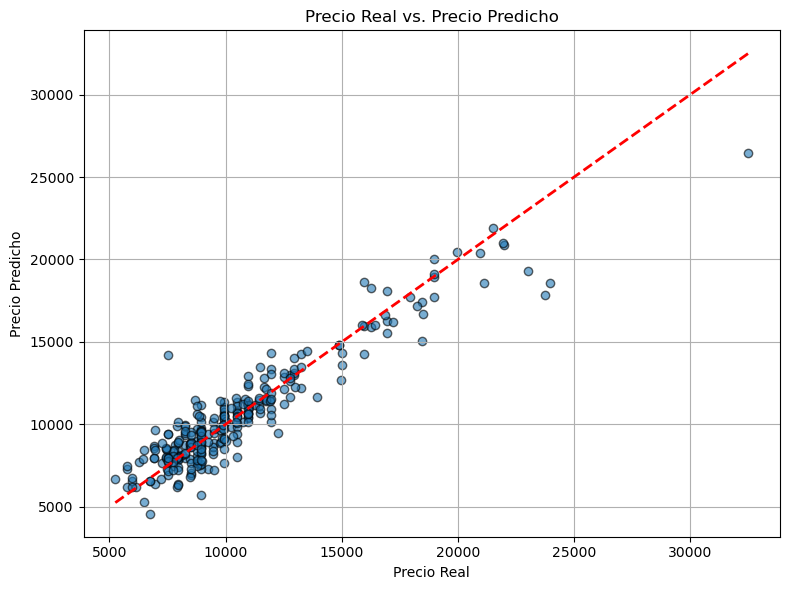

In [300]:
# Plot: Real vs. Predicho
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Precio Predicho")
plt.grid(True)
plt.tight_layout()

real_vs_pred_path = os.path.join("mlartifacts", "actual_vs_predicted.png")
plt.savefig(real_vs_pred_path)
mlflow.log_artifact(real_vs_pred_path)
plt.show()

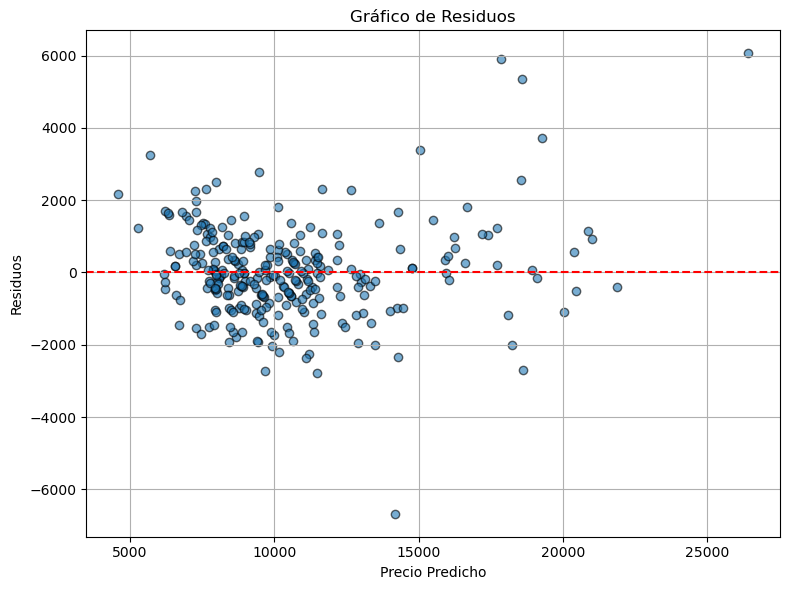

In [301]:
# Análisis de residuos
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Precio Predicho")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()

residuals_path = os.path.join("mlartifacts", "residuals_plot.png")
plt.savefig(residuals_path)
mlflow.log_artifact(residuals_path)
plt.show()

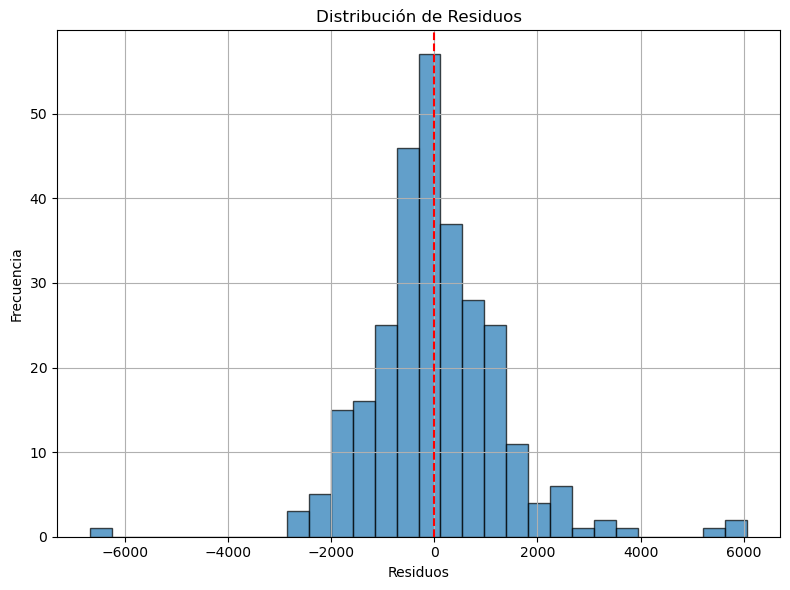

In [302]:
# Histograma de residuos
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()







## Comparativa de Modelos



In [303]:
# Crear tabla comparativa
results_df = pd.DataFrame({
    "Modelo": ["OLS", "Lasso", "Lasso+PCA"],
    "RMSE": [rmse, rmse_lasso, rmse_pca],
    "MAE": [mae, mae_lasso, mean_absolute_error(y_test, y_pred_pca)],
    "R²": [r2_sklearn, r2_lasso, r2_pca],
    "Num. Features": [X_train.shape[1], len(lasso_features), pca.n_components_]
})

print("Comparativa de modelos:")
print(results_df)

ValueError: Found input variables with inconsistent numbers of samples: [286, 574]